In [1]:
#import some tools that we will use
import skimage.io
import skimage.measure
import skimage.feature
import skimage.segmentation
from skimage.morphology import disk
import scipy.ndimage
import numpy
import matplotlib.pyplot as plt
from generate_spot_positions import GenerateSpotPositionsJob
from models.image_filename_glob import ImageFilenameGlob

import scipy.ndimage
from pathlib import Path

In [26]:
#define paths to images
image_folder = "C:\\Users\\finne\\Documents\\python\\cropped_cells_20210216\\"

# Image_path = "/Users/kevin/Desktop/generate_all_cropped_cell_images_output/Plate1_12-30-20_18-38-45_B02_T0001F002L01A02ZXXC03_cropped_117.npy"

well_ID = "B07"
field_ID = 7
channel_ID = 2

# Find 10 random nuclei
image_path = Path(image_folder)

image_filename_glob = image_path.glob(str(ImageFilenameGlob(well = well_ID, f = field_ID, c = channel_ID, suffix="_cropped_???", extension="npy")))

images_selected_random = [next(image_filename_glob) for _ in range(5)]

for image_selected in images_selected_random:
    print(image_selected)

C:\Users\finne\Documents\python\cropped_cells_20210216\AssayPlate_PerkinElmer_CellCarrier-384_B07_T0001F007L01A01ZXXC02_cropped_017.npy
C:\Users\finne\Documents\python\cropped_cells_20210216\AssayPlate_PerkinElmer_CellCarrier-384_B07_T0001F007L01A01ZXXC02_cropped_018.npy
C:\Users\finne\Documents\python\cropped_cells_20210216\AssayPlate_PerkinElmer_CellCarrier-384_B07_T0001F007L01A01ZXXC02_cropped_019.npy
C:\Users\finne\Documents\python\cropped_cells_20210216\AssayPlate_PerkinElmer_CellCarrier-384_B07_T0001F007L01A01ZXXC02_cropped_020.npy
C:\Users\finne\Documents\python\cropped_cells_20210216\AssayPlate_PerkinElmer_CellCarrier-384_B07_T0001F007L01A01ZXXC02_cropped_021.npy


In [31]:
# SET CONTRAST THRESHOLD HERE:
contrast_threshold = 2.5

segmenters = [GenerateSpotPositionsJob(image, "no/output", contrast_threshold) for image in images_selected_random]

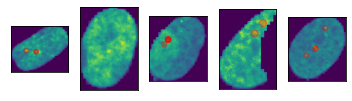

In [32]:
# display image and found spots -- these coordinates (+ offset) can be used to look up precalculated z-position and radial position. 
fig, axs = plt.subplots(1, 5)

for i, ax in enumerate(axs):
    ax.imshow(segmenters[i].image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for spot in segmenters[i].spots:
        circle=plt.Circle((spot[1], spot[0]), 7, color='r', alpha=0.3)
        ax.add_patch(circle)

fig.show()

In [ ]:
# read in config file into hash
# change hash as needed to reflect parameters above
# overwrite config file with new values